Mean Squared Error: 10667.807400000005
R^2 Score: 0.9448639568285004
Best parameters: {'regressor__max_depth': 10, 'regressor__n_estimators': 100}
Best Model Mean Squared Error: 10650.101013964488
Best Model R^2 Score: 0.9449554714226677


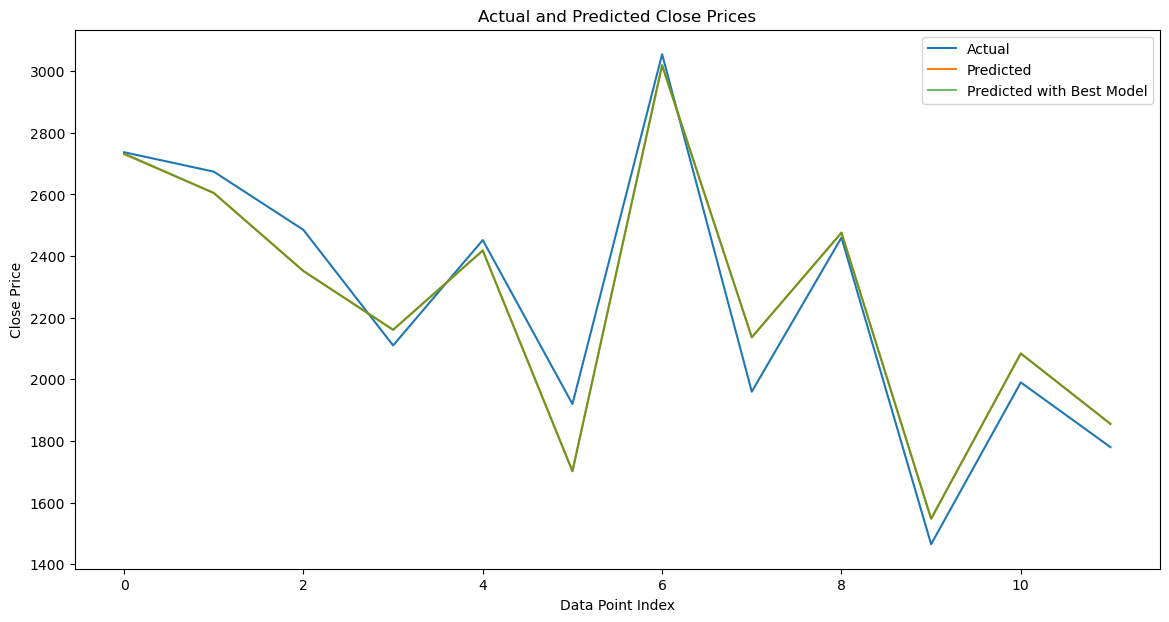

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Loading the dataset
df = pd.read_csv('upbit_arb_60_days.csv')

# Assuming 'Close' is the target and 'Volume' is one of the features along with other features
# Dropping 'Close' from X and setting it as y
X = df.drop(['Close'], axis=1)
y = df['Close']

# Assuming 'Volume' is numeric, it will be included in numeric_features
# Update the selection of numeric and categorical features based on your dataset
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object']).columns

# Creating transformers for numeric and categorical features
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combining transformers into a ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

# Creating a pipeline that includes preprocessing and the model
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(n_estimators=100, random_state=42))
])

# Splitting data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Training the model
model_pipeline.fit(X_train, y_train)

# Predicting test set results
y_pred = model_pipeline.predict(X_test)

# Evaluating the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'R^2 Score: {r2}')

# Optional: Hyperparameter tuning
param_grid = {
    'regressor__n_estimators': [100, 200],
    'regressor__max_depth': [None, 10, 20],
}

grid_search = GridSearchCV(model_pipeline, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train, y_train)

print("Best parameters:", grid_search.best_params_)
best_model = grid_search.best_estimator_

# Re-evaluating the model with best parameters
y_pred_best = best_model.predict(X_test)
mse_best = mean_squared_error(y_test, y_pred_best)
r2_best = r2_score(y_test, y_pred_best)

print(f'Best Model Mean Squared Error: {mse_best}')
print(f'Best Model R^2 Score: {r2_best}')

# Plotting the actual vs predicted values
plt.figure(figsize=(14, 7))
plt.plot(y_test.reset_index(drop=True), label='Actual')
plt.plot(y_pred, label='Predicted')
plt.plot(y_pred_best, label='Predicted with Best Model', alpha=0.7)
plt.title('Actual and Predicted Close Prices')
plt.xlabel('Data Point Index')
plt.ylabel('Close Price')
plt.legend()
plt.show()

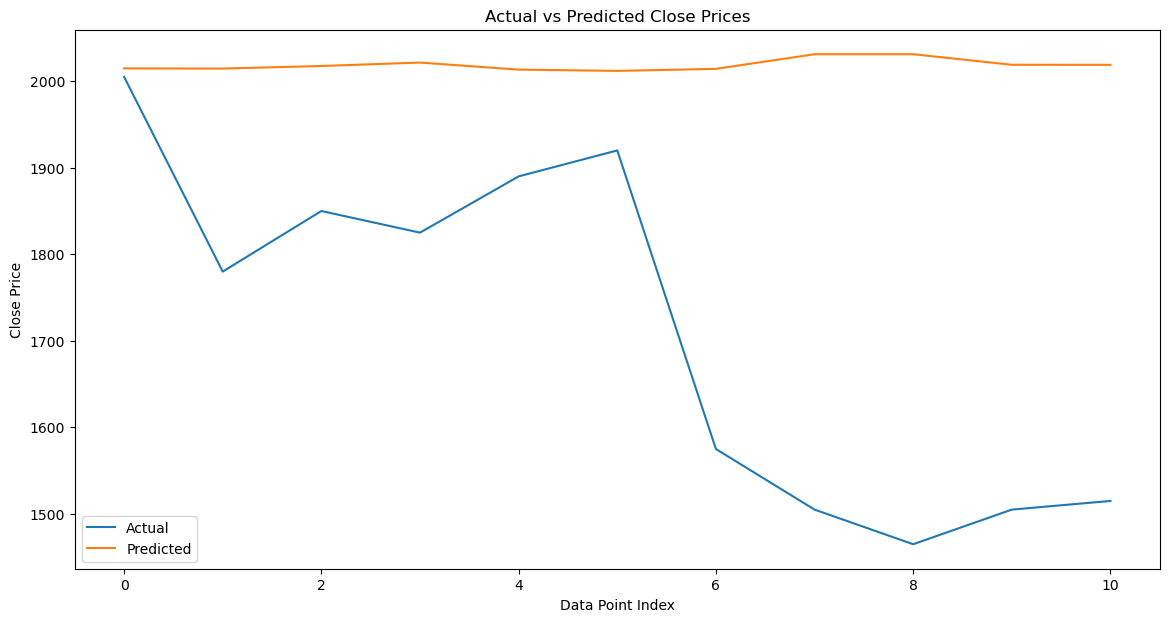

MSE: 132163.95142045457, R2: -2.6207662104908644, MAE: 306.6386363636364


In [13]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import matplotlib.pyplot as plt

# 데이터셋 로드
df = pd.read_csv('upbit_arb_60_days.csv')

# 피처 엔지니어링 함수
def create_lagged_features(df, max_lag, rolling_window_size):
    for lag in range(1, max_lag + 1):
        df[f'Close_lag_{lag}'] = df['Close'].shift(lag)
    df['Volume_lag_1'] = df['Volume'].shift(1)
    df['Close_rolling_mean'] = df['Close'].shift(1).rolling(window=rolling_window_size).mean()
    df['Close_rolling_std'] = df['Close'].shift(1).rolling(window=rolling_window_size).std()
    return df.dropna()

# 피처 엔지니어링 적용
max_lag_periods = 5
rolling_window_size = 3
df = create_lagged_features(df, max_lag_periods, rolling_window_size)

# 타겟 변수 정의
X = df.drop('Close', axis=1)
y = df['Close']

# 수치형 및 범주형 피처 식별
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object']).columns

# 전처리 파이프라인
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])
preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)
])

# 모델 파이프라인
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(random_state=42))
])

# 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

# 하이퍼파라미터 튜닝
param_grid = {
    'regressor__n_estimators': [100, 200],
    'regressor__max_depth': [None, 10, 20],
    'regressor__min_samples_split': [2, 5],
    'regressor__min_samples_leaf': [1, 2]
}
tscv = TimeSeriesSplit(n_splits=5)
grid_search = GridSearchCV(model_pipeline, param_grid, cv=tscv)
grid_search.fit(X_train, y_train)

# 최적 모델로 예측
y_pred = grid_search.predict(X_test)

# 모델 평가
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

# 결과 시각화
plt.figure(figsize=(14, 7))
plt.plot(y_test.reset_index(drop=True), label='Actual')
plt.plot(y_pred, label='Predicted')
plt.title('Actual vs Predicted Close Prices')
plt.xlabel('Data Point Index')
plt.ylabel('Close Price')
plt.legend()
plt.show()

# 평가 지표 출력
print(f'MSE: {mse}, R2: {r2}, MAE: {mae}')


# 테스트1

In [19]:
import requests
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset

# ARB 데이터 로딩
def fetch_upbit_data(market_code='KRW-ARB', count=60):
    url = "https://api.upbit.com/v1/candles/days"
    params = {"market": market_code, "count": str(count)}
    response = requests.get(url, params=params)
    data = response.json()
    df = pd.DataFrame(data)
    df['timestamp'] = pd.to_datetime(df['candle_date_time_kst']).dt.tz_localize(None)
    df = df[['timestamp', 'opening_price', 'high_price', 'low_price', 'trade_price', 'candle_acc_trade_volume']]
    df.columns = ['Timestamp', 'Open', 'High', 'Low', 'Close', 'Volume']
    df.set_index('Timestamp', inplace=True)
    return df.sort_index()

df = fetch_upbit_data()

# 데이터 스케일링
scaler = MinMaxScaler()
df[['Close', 'Volume']] = scaler.fit_transform(df[['Close', 'Volume']])

# 기본 피처 엔지니어링
df['Close_lag_1'] = df['Close'].shift(1)
df['Volume_lag_1'] = df['Volume'].shift(1)
df.dropna(inplace=True)

class ARBDataset(Dataset):
    def __init__(self, df, window_size=60):
        self.data = df
        self.window_size = window_size
    
    def __len__(self):
        # 데이터셋 길이 계산 시 윈도우 크기 고려
        return len(self.data) - self.window_size
    
    def __getitem__(self, idx):
        x = self.data.iloc[idx:idx+self.window_size, :-1].values
        y = self.data.iloc[idx+self.window_size, -1]
        return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)

class TransformerModel(nn.Module):
    def __init__(self, input_dim, model_dim, num_heads, num_layers, output_dim):
        super(TransformerModel, self).__init__()
        self.layer_norm = nn.LayerNorm(model_dim)
        self.positional_encoding = nn.Parameter(torch.zeros(1, 60, model_dim))
        encoder_layers = nn.TransformerEncoderLayer(model_dim, num_heads, model_dim)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, num_layers)
        self.fc_out = nn.Linear(model_dim, output_dim)
    
    def forward(self, src):
        src += self.positional_encoding[:, :src.size(1)]
        src = self.layer_norm(src)
        output = self.transformer_encoder(src)
        output = self.fc_out(output)
        return output

# 데이터셋 준비
class ARBDataset(Dataset):
    def __init__(self, df, window_size=60):
        self.data = df
        self.window_size = window_size
    
    def __len__(self):
        return len(self.data) - self.window_size
    
    def __getitem__(self, idx):
        x = self.data.iloc[idx:idx+self.window_size, :-1].values
        y = self.data.iloc[idx+self.window_size, -1]
        return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)

dataset = ARBDataset(df)
dataloader = DataLoader(dataset, batch_size=32, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = TransformerModel(input_dim=df.shape[1]-1, model_dim=512, num_heads=8, num_layers=3, output_dim=1).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# 학습 루프
epochs = 1000
for epoch in range(epochs):
    model.train()
    for batch_idx, (x_batch, y_batch) in enumerate(dataloader):
        optimizer.zero_grad()
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        output = model(x_batch).squeeze(-1)
        loss = criterion(output, y_batch)
        loss.backward()
        optimizer.step()
    print(f'Epoch {epoch+1}, Loss: {loss.item()}')

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

# RandomForestRegressor 모델 준비
rf_model = make_pipeline(StandardScaler(), RandomForestRegressor(n_estimators=100))

# 훈련 및 검증 데이터 분할
X = df.drop(['Close'], axis=1)
y = df['Close']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 모델 학습
rf_model.fit(X_train, y_train)

# 모델 예측
y_pred = rf_model.predict(X_test)


C:\Users\ether\anaconda3\Lib\site-packages\torch\nn\modules\transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


ValueError: __len__() should return >= 0

# 테스트 2

C:\Users\ether\anaconda3\Lib\site-packages\torch\nn\modules\transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
C:\Users\ether\anaconda3\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([10])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 0, Loss: 11.387274461090565
Epoch 10, Loss: 0.09524747892282903
Epoch 20, Loss: 0.11209834691602737
Epoch 30, Loss: 0.07131239398615435
Epoch 40, Loss: 0.08084053101891187


C:\Users\ether\AppData\Local\Temp\ipykernel_21596\2376652793.py:114: FutureWarning: Argument `closed` is deprecated in favor of `inclusive`.
  future_dates = pd.date_range(start=last_60_days[-1], periods=future_steps + 1, closed='right')


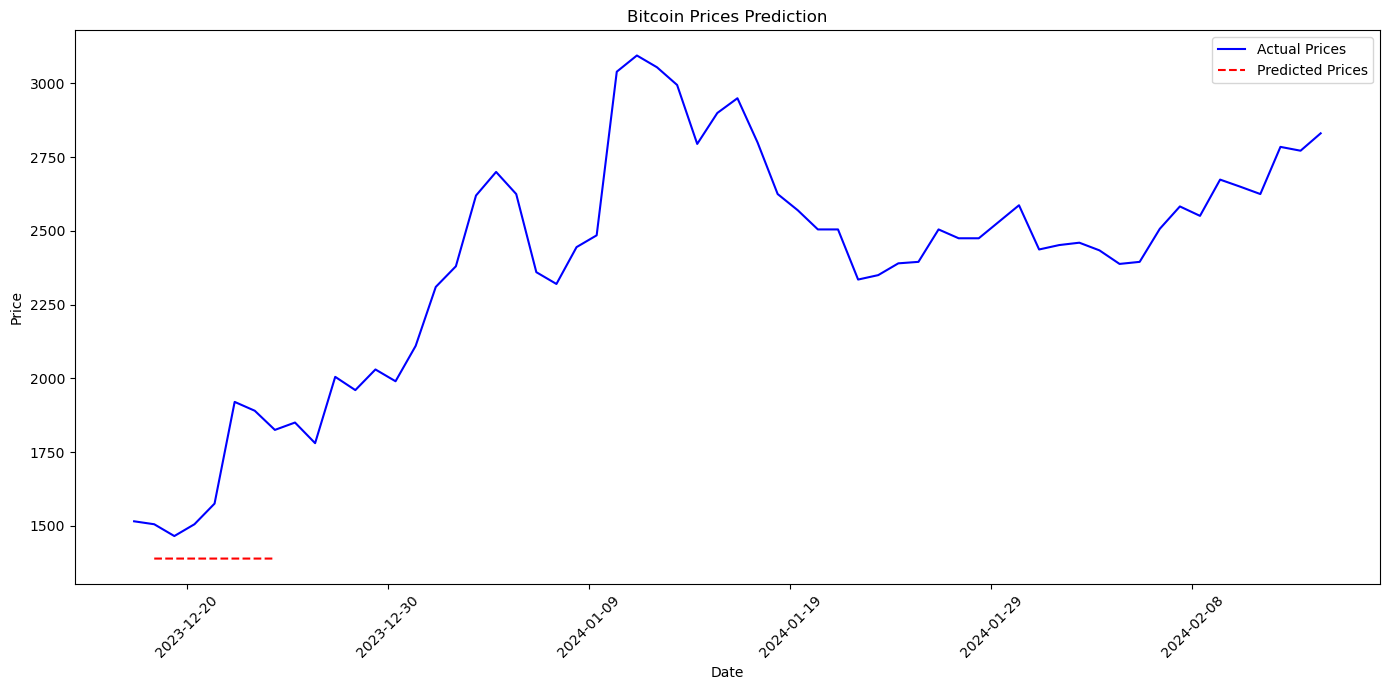

In [1]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, Dataset
import torch
import torch.nn as nn
import torch.optim as optim
from scipy.signal import find_peaks
import matplotlib.dates as mdates

# 데이터 로딩 및 전처리
def get_bitcoin_data_60_days():
    url = "https://api.upbit.com/v1/candles/days"
    querystring = {"market":"KRW-ARB","count":"60"}
    response = requests.get(url, params=querystring)
    data = response.json()
    df = pd.DataFrame(data)[['candle_date_time_kst', 'trade_price', 'candle_acc_trade_volume']]
    df.columns = ['DateTime', 'Close', 'Volume']
    df['DateTime'] = pd.to_datetime(df['DateTime'])
    df.set_index('DateTime', inplace=True)
    return df

df = get_bitcoin_data_60_days()
scaler = MinMaxScaler()
df[['Close', 'Volume']] = scaler.fit_transform(df[['Close', 'Volume']])

# 데이터셋 클래스
class BitcoinDataset(Dataset):
    def __init__(self, df, window_size=10):
        self.df = df
        self.window_size = window_size

    def __len__(self):
        return len(self.df) - self.window_size

    def __getitem__(self, idx):
        x = self.df.iloc[idx:idx+self.window_size].values
        y = self.df.iloc[idx+1:idx+self.window_size+1].values[:, 0]
        return torch.tensor(x, dtype=torch.float), torch.tensor(y, dtype=torch.float)

dataset = BitcoinDataset(df[['Close', 'Volume']], window_size=10)
loader = DataLoader(dataset, batch_size=1, shuffle=False)

# 트랜스포머 모델
class TransformerModel(nn.Module):
    def __init__(self, input_dim, model_dim, num_heads, num_layers, dropout=0.1):
        super(TransformerModel, self).__init__()
        self.model_dim = model_dim  # model_dim 속성 추가
        self.input_linear = nn.Linear(input_dim, model_dim)  # 입력 차원을 모델 차원으로 변환
        self.pos_encoder = nn.Embedding(5000, model_dim)
        encoder_layers = nn.TransformerEncoderLayer(model_dim, num_heads, model_dim * 2, dropout)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, num_layers)
        self.decoder = nn.Linear(model_dim, 1)
        self.init_weights()

    def init_weights(self):
        initrange = 0.1
        self.decoder.bias.data.zero_()
        self.decoder.weight.data.uniform_(-initrange, initrange)

    def forward(self, src):
        src = self.input_linear(src)  # 입력 데이터를 모델 차원으로 변환
        src *= np.sqrt(self.model_dim)
        src_positions = torch.arange(0, src.size(1)).unsqueeze(0).to(src.device)
        src = src + self.pos_encoder(src_positions).permute(1, 0, 2)
        output = self.transformer_encoder(src)
        output = self.decoder(output)
        return output[:, -1]

model = TransformerModel(input_dim=2, model_dim=512, num_heads=8, num_layers=3).to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))

# 모델 학습
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

epochs = 50
for epoch in range(epochs):
    total_loss = 0
    for x, y in loader:
        x, y = x.to(torch.device("cuda" if torch.cuda.is_available() else "cpu")), y.to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))
        optimizer.zero_grad()
        output = model(x.permute(1, 0, 2))
        loss = criterion(output.squeeze(), y[:, -1])
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Loss: {total_loss / len(loader)}')

# 다음 1주일 간의 데이터 예측
model.eval()
future_steps = 7
predictions = []
last_window = df[['Close', 'Volume']].values[-10:]
with torch.no_grad():
    for _ in range(future_steps):
        last_window_tensor = torch.tensor(last_window, dtype=torch.float).unsqueeze(1).to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))
        prediction = model(last_window_tensor.permute(1, 0, 2)).cpu().numpy()
        predictions.append(prediction[0])
        last_window = np.roll(last_window, -1, axis=0)
        last_window[-1, 0] = prediction[0]  # Assume volume stays constant for simplicity

# Add the last volume value to the predicted prices
predictions_with_volume = np.hstack((np.array(predictions).reshape(-1, 1), df[['Volume']].values[-7:]))

# Now you can use inverse_transform
predicted_prices = scaler.inverse_transform(predictions_with_volume)[:, 0]

# Visualization
last_60_days = df.index[-60:]
actual_prices_scaled_back = scaler.inverse_transform(df[['Close', 'Volume']])[:, 0][-60:]
future_dates = pd.date_range(start=last_60_days[-1], periods=future_steps + 1, closed='right')

plt.figure(figsize=(14, 7))
plt.plot(last_60_days, actual_prices_scaled_back, label='Actual Prices', color='blue')
plt.plot(future_dates, predicted_prices.squeeze(), label='Predicted Prices', color='red', linestyle='--')
plt.title('Bitcoin Prices Prediction')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=10))
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 테스트 3

In [3]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import make_pipeline
import pandas as pd
import numpy as np

# 데이터 로딩 및 전처리
file_path = 'upbit_arb_60_days.csv'
df = pd.read_csv(file_path)

# 날짜 및 시간 열을 datetime으로 변환하고 수치 특성으로 변환
df['DateTime'] = pd.to_datetime(df['DateTime'])
df['Year'] = df['DateTime'].dt.year
df['Month'] = df['DateTime'].dt.month
df['Day'] = df['DateTime'].dt.day
df['Hour'] = df['DateTime'].dt.hour
df['Minute'] = df['DateTime'].dt.minute
df.drop(['DateTime'], axis=1, inplace=True)

# MinMaxScaler를 사용하여 수치 데이터 스케일링
scaler = MinMaxScaler()
df.iloc[:, :-1] = scaler.fit_transform(df.iloc[:, :-1])

class ARBDataset(Dataset):
    def __init__(self, df, window_size=60):
        self.data = df
        self.window_size = window_size
    
    def __len__(self):
        return max(0, len(self.data) - self.window_size)
    
    def __getitem__(self, idx):
        x = self.data.iloc[idx:idx+self.window_size, :-1].values
        y = self.data.iloc[idx+self.window_size, -1]
        return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)

class TransformerModel(nn.Module):
    def __init__(self, input_dim, model_dim, num_heads, num_layers, output_dim):
        super(TransformerModel, self).__init__()
        self.layer_norm = nn.LayerNorm(model_dim)
        self.positional_encoding = nn.Parameter(torch.zeros(1, window_size, model_dim))
        encoder_layers = nn.TransformerEncoderLayer(model_dim, num_heads, model_dim // 2, dropout=0.1)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, num_layers)
        self.fc_out = nn.Linear(model_dim, output_dim)
    
    def forward(self, src):
        src += self.positional_encoding[:, :src.size(1)]
        src = self.layer_norm(src)
        output = self.transformer_encoder(src)
        output = self.fc_out(output[:, -1, :])  # 가장 마지막 시퀀스만 사용
        return output

# 데이터셋과 DataLoader 준비
window_size = 60  # Window size of the time series data to use
dataset = ARBDataset(df, window_size=window_size)
print("Dataset size:", len(dataset))  # Debug statement to print the size of the dataset

train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
print("Train size:", train_size)  # Debug statement to print the train size
print("Test size:", test_size)  # Debug statement to print the test size

if train_size <= 0 or test_size <= 0:
    window_size -= 1  # 윈도우 크기를 1만큼 감소시킴
    train_size = int(0.8 * len(dataset))
    test_size = len(dataset) - train_size
    
# Ensure that we have a non-zero size for train and test datasets
if train_size <= 0 or test_size <= 0:
    raise ValueError("Train size or test size is zero. Please check your dataset and window size.")

train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# 모델, 손실 함수, 옵티마이저 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Corrected by removing window_size from the TransformerModel instantiation
model = TransformerModel(input_dim=df.shape[1]-1, model_dim=512, num_heads=8, num_layers=3, output_dim=1).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# learning loop
epochs = 100 # Adjust to the appropriate number of epochs during actual training
for epoch in range(epochs):
    model.train()
    train_loss = 0
    for x_batch, y_batch in train_loader:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        output = model(x_batch).squeeze(-1)
        loss = criterion(output, y_batch)
        loss.backward()  # Corrected typo
        optimizer.step()
        train_loss += loss.item()
    train_loss /= len(train_loader)
    print(f'Epoch {epoch+1}, Train Loss: {train_loss:.4f}')
    
# RandomForestRegressor를 위한 데이터 준비 및 모델 학습
X = df.drop(['Close'], axis=1)  # 'Close' 열이 타겟 변수라고 가정
y = df['Close']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rf_model = make_pipeline(StandardScaler(), RandomForestRegressor(n_estimators=100))
rf_model.fit(X_train, y_train)
y_pred = rf_model.predict(X_test)

Dataset size: 0
Train size: 0
Test size: 0


C:\Users\ether\AppData\Local\Temp\ipykernel_21596\381684745.py:26: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.iloc[:, :-1] = scaler.fit_transform(df.iloc[:, :-1])


ValueError: Train size or test size is zero. Please check your dataset and window size.